**Some leading questions:**
* implement original script
* implement with a 4 x 4 and a bomb reward of -20, gold reward of 10
* add 4 actions (DIAG_UP_LEFT, DIAG_UP_RIGHT, DIAG_DOWN_LEFT, DIAG_DOWN_RIGHT)
* what happens if you set reward to be positive? Does the game ever end?
* how could we randomly initialize the bomb, gold and start point?
* add a 2nd piece of gold? (A 3rd terminal state)
* "animation"
* enriching GridWorld input arguments

We transformed Grid World script with Q-learning (https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-/blob/master/Gridworld.ipynb) to random walk (inspiration, caveat that there are a few errors in the documentation: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/RandomWalk/RandomWalk(n-step).ipynb) 

Bunch of different RL algorithms implemented here: https://github.com/MJeremy2017/reinforcement-learning-implementation \
The Towards Data Science blockers can be bypassed on Chrome through this little hack (*shhhhhh*): https://github.com/iamadamdev/bypass-paywalls-chrome

# Transforming Grid World to Random Walk

In [72]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
height = 1
width = 21
grid=np.zeros(( height, width)) - 1 

In [74]:
class RandomWalk:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 1
        self.width = 21
        self.grid = np.zeros(( self.height, self.width)) # create a height x width matrix full of -1 Rewards
        
        # Set random start location for the agent
        self.current_location = ( 0, 10 ) # 0 inclusively, 5 exlusive
        
        # Set locations for the bomb and the gold
        self.bomb_location = (0,0)
        self.gold_location = (0,20)
        self.terminal_states = [ self.bomb_location, self.gold_location]
        
        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -1
        self.grid[ self.gold_location[0], self.gold_location[1]] = 1
        
        # Set available actions
        self.actions = ['LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self): # turned 2D coordinates into a "map"
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
            
        # LEFT
        if action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [75]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [76]:
class Q_Agent_RW():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon: # explore
            action = available_actions[np.random.randint(0, len(available_actions))]
        else: # greedy action (exploit)
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values()) # choose max out of 4 vals
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [77]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

## Tests with Random Agent

In [78]:
env = RandomWalk()

In [79]:
rw_agent = RandomAgent()

In [80]:
print("Current position of the agent =", env.current_location)

Current position of the agent = (0, 10)


In [81]:
print(env.agent_on_map())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [82]:
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)

Available_actions = ['LEFT', 'RIGHT']


In [83]:
chosen_action = rw_agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)

Randomly chosen action = RIGHT


In [84]:
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)

Reward obtained = 0.0


In [85]:
print("Current position of the agent =", env.current_location)

Current position of the agent = (0, 11)


In [86]:
print(env.agent_on_map())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


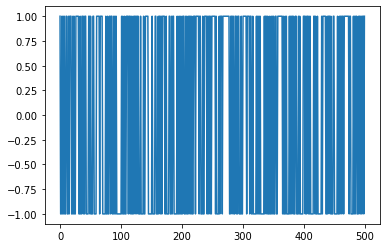

In [87]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Tests with non-random agent

In [88]:
env = RandomWalk()
agent = Q_Agent_RW(env)

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (0, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [89]:
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)

Available_actions = ['LEFT', 'RIGHT']
Randomly chosen action = RIGHT


In [90]:
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Reward obtained = 0.0
Current position of the agent = (0, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


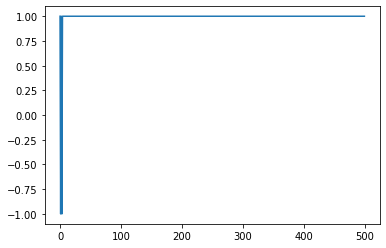

In [91]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

# Grid World

In [93]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 5
        self.width = 5
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))
        
        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]
        
        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

class Q_Agent_GW():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

## Testing random agent

In [94]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


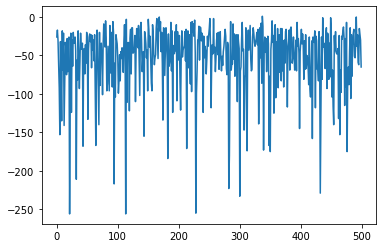

In [95]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Hyperparameter testing (iterating through different values of Epsilon for grid world Q agent!)

In [112]:
epsilons=[0.01,0.05,0.1,0.4,1]

In [116]:
n_hyperparams=len(epsilons)

In [113]:
environment = GridWorld()
rewards_per_eps=[]
for val in epsilons:
    agentQ = Q_Agent_GW(environment,epsilon=val)
    reward_per_episode = play(environment, agentQ, trials=500, learn=True)
    rewards_per_eps.append(reward_per_episode)

Text(0.5, 1.0, 'Rewards per episode for 5 different values of Epsilon')

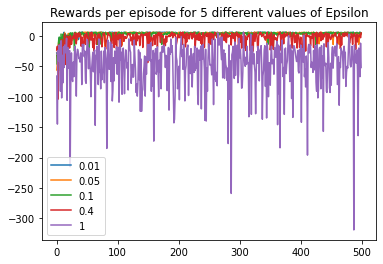

In [115]:
for i in range(n_hyperparams)
plt.plot(rewards_per_eps[0])
plt.plot(rewards_per_eps[1])
plt.plot(rewards_per_eps[2])
plt.plot(rewards_per_eps[3])
plt.plot(rewards_per_eps[4])
plt.legend(epsilons)
plt.title("Rewards per episode for 5 different values of Epsilon")

Text(0.5, 1.0, 'Rewards per episode for 5 different values of Epsilon')

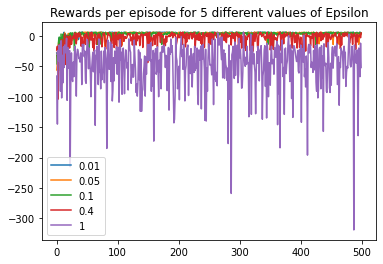

In [121]:
for i in range(n_hyperparams):
    plt.plot(rewards_per_eps[i])
plt.legend(epsilons)
plt.title(f"Rewards per episode for {n_hyperparams} different values of Epsilon")

Text(0.5, 1.0, 'Rewards per episode for 5 different values of Gamma')

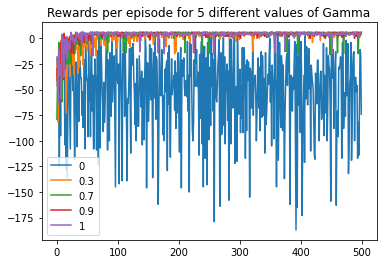

In [124]:
gammas=[0,0.3,0.7,0.9,1]
n_hyperparams=len(gammas)

environment = GridWorld()
rewards_per_eps=[]
for val in gammas:
    agentQ = Q_Agent_GW(environment,gamma=val)
    reward_per_episode = play(environment, agentQ, trials=500, learn=True)
    rewards_per_eps.append(reward_per_episode)

for i in range(n_hyperparams):
    plt.plot(rewards_per_eps[i])
plt.legend(gammas)
plt.title(f"Rewards per episode for {n_hyperparams} different values of Gamma")

Text(0.5, 1.0, 'Rewards per episode for 5 different values of Alpha')

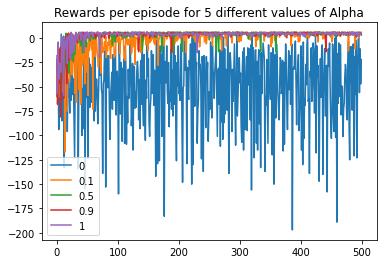

In [125]:
alphas=[0,0.1,0.5,0.9,1]
n_hyperparams=len(alphas)
environment = GridWorld()
rewards_per_eps=[]
for val in alphas:
    agentQ = Q_Agent_GW(environment,gamma=val)
    reward_per_episode = play(environment, agentQ, trials=500, learn=True)
    rewards_per_eps.append(reward_per_episode)

for i in range(n_hyperparams):
    plt.plot(rewards_per_eps[i])
plt.legend(alphas)
plt.title(f"Rewards per episode for {n_hyperparams} different values of Alpha")